In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tfa-nightly

In [ ]:
!pip install tensorflow-addons

In [4]:
# Import Library
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D,MaxPooling2D
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import RMSprop,SGD,Adam,Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

In [ ]:
# Variable Definition
num_classes=7
height,width=48,48
batch_size=128

In [ ]:
!rm -rf fer2013
!mkdir fer2013
!mkdir fer2013/train
!mkdir fer2013/test
! unzip -q '/content/drive/MyDrive/VIN/fer2013/train.zip' -d fer2013/train
! unzip -q '/content/drive/MyDrive/VIN/fer2013/test-public.zip' -d fer2013/valid
! unzip -q '/content/drive/MyDrive/VIN/fer2013/test-private.zip' -d fer2013/test

In [ ]:
# Dataset Directory
train_dir='fer2013/train'
validation_dir='fer2013/valid'
test_dir = 'fer2013/test'

In [ ]:
def smooth_labels(y, smooth_factor):
    '''Convert a matrix of one-hot row-vector labels into smoothed versions.
    https://www.dlology.com/blog/bag-of-tricks-for-image-classification-with-convolutional-neural-networks-in-keras/?fbclid=IwAR2RXBIUkuSdc21cQd3n8AG9CmGtC7MbVgEj3SFm-cfIDyHcexp7YjIhJKs

    # Arguments
        y: matrix of one-hot row-vector labels to be smoothed
        smooth_factor: label smoothing factor (between 0 and 1)

    # Returns
        A matrix of smoothed labels.
    '''
    assert len(y.shape) == 2
    if 0 <= smooth_factor <= 1:
        # label smoothing ref: https://www.robots.ox.ac.uk/~vgg/rg/papers/reinception.pdf
        y *= 1 - smooth_factor
        y += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range = [0.8,1.2],
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
def train_gen(train_datagen) :
  while True :
    x, y = next(train_datagen)
    y = smooth_labels(y, 0.1)
    yield x, y

In [ ]:
train_generator = train_datagen.flow_from_directory(
 train_dir,
 color_mode='rgb',
 target_size=(224,224),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
 validation_dir,
 color_mode='rgb',
 target_size=(224,224),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=True)

test_generator = test_datagen.flow_from_directory(
 test_dir,
 color_mode='rgb',
 target_size=(224,224),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=True)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [2]:
!sudo pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install Keras-Applications

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-33l69zed
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-33l69zed
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=9ab22e3299f55f76eb5debf1ad903cc3a1df57ff3b5b78f2e2302edc9d3c8f3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-8iw1kiqc/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
     |████████████████████████████████| 51kB 2.7MB/s 


In [6]:
# continue train from check point
from keras_vggface.vggface import VGGFace
import tensorflow as tf

vgg_notop = VGGFace(model='vgg16', weights=None, include_top=False, input_shape=(224, 224, 3), pooling='avg')
last_layer = vgg_notop.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(0.2)(x)
# x = Dense(4096, activation='relu', name='fc6')(x)
x = Dense(32, activation='relu', name='fc7')(x)
x = Dropout(0.2)(x)

#for i in range(19):
#    vgg_notop.layers[i].trainable = False

out = Dense(7, activation='softmax', name='classifier')(x)

model = tf.keras.Model(vgg_notop.input, out)
#model.load_weights('/content/drive/MyDrive/EmotionDetectionModelv5.h5')


In [7]:
for layer in model.layers[:-9]:
    layer.trainable = False
for layer in model.layers[-9:]:
    layer.trainable = True

In [ ]:
# Compile and Train
checkpoint = ModelCheckpoint('/content/drive/MyDrive/VIN/MODEL/VGGFace16.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=15,
                          verbose=1,
                          restore_best_weights=True
                          )
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)
callbacks = [earlystop,checkpoint,reduce_lr]

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)

In [8]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)      

In [ ]:
model.compile(loss='categorical_crossentropy',
 optimizer = optimizer,
 metrics=['accuracy'])

nb_train_samples = 28709
nb_validation_samples = 3589
epochs=50

history=model.fit(
 train_gen(train_generator),
 steps_per_epoch=nb_train_samples//batch_size,
 epochs=epochs,
 callbacks=callbacks,
 validation_data=validation_generator,
 validation_steps=nb_validation_samples//batch_size)

Epoch 1/50
224/224 [==============================] - ETA: 0s - loss: 1.1011 - accuracy: 0.6988
Epoch 00001: val_accuracy improved from -inf to 0.66713, saving model to /content/drive/MyDrive/VIN/MODEL/VGGFace16.h5
224/224 [==============================] - 492s 2s/step - loss: 1.1011 - accuracy: 0.6988 - val_loss: 0.9275 - val_accuracy: 0.6671
Epoch 2/50
224/224 [==============================] - ETA: 0s - loss: 1.0786 - accuracy: 0.7148
Epoch 00002: val_accuracy did not improve from 0.66713
224/224 [==============================] - 490s 2s/step - loss: 1.0786 - accuracy: 0.7148 - val_loss: 0.9378 - val_accuracy: 0.6596
Epoch 3/50
224/224 [==============================] - ETA: 0s - loss: 1.0796 - accuracy: 0.7130
Epoch 00003: val_accuracy improved from 0.66713 to 0.66825, saving model to /content/drive/MyDrive/VIN/MODEL/VGGFace16.h5
224/224 [==============================] - 493s 2s/step - loss: 1.0796 - accuracy: 0.7130 - val_loss: 0.9301 - val_accuracy: 0.6682
Epoch 4/50
224/224 [

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


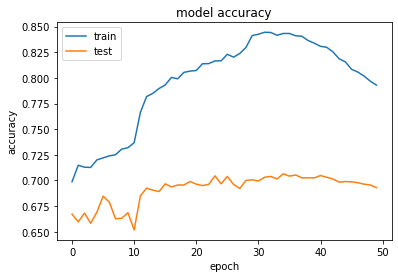

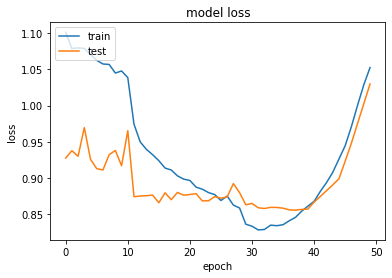

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("/content/drive/MyDrive/VIN/MODEL/VGGFace16.h5")

In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3589 // batch_size)
print('test loss, test acc:', results_test)


# Evaluate on test data
Instructions for updating:
Please use Model.evaluate, which supports generators.
test loss, test acc: [0.8589019775390625, 0.7067522406578064]


In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(validation_generator, 3589 // batch_size)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [0.9052081108093262, 0.6888951063156128]


In [ ]:
emotions_dirt = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}

In [ ]:
def get_key(val):
    for key, value in emotions_dirt.items():
         if val == value:
             return key

In [ ]:
import cv2
import numpy as np
from skimage.transform import rescale, resize
def image_predict(image, model):
  img = cv2.imread(image)
  img = resize(img, (224, 224, 3))
  img = img[np.newaxis,:,:,:]
  return emotions_dirt[np.argmax(model.predict(img))]


In [ ]:
image = "/content/happy-028713.png"
image_predict(image, model)

AttributeError: ignored

In [ ]:
path = '/content/fer2013/test/'
images = []
y_label = []
for emotion in os.listdir(path):
  emo = emotion.split()[1]
  print(emo)
  key = get_key(emo)
  path_of_emotion = os.path.join(path, emotion)
  y_label += [key] * len(os.listdir(path_of_emotion))
  for image in os.listdir(path_of_emotion):
    path_of_image = os.path.join(path_of_emotion, image)
    images.append(path_of_image)
len(images)

surprise
fear
disgust
neutral
sad
happy
angry


3589

In [ ]:
np.array(y_label).shape

(3589,)

In [ ]:
y_predict = [image_predict(image, model) for image in images]

In [ ]:
y_predict = [get_key(value) for value in y_predict]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y_label, y_predict)

0.694901086653664

In [ ]:
a =confusion_matrix(y_label, y_predict)

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

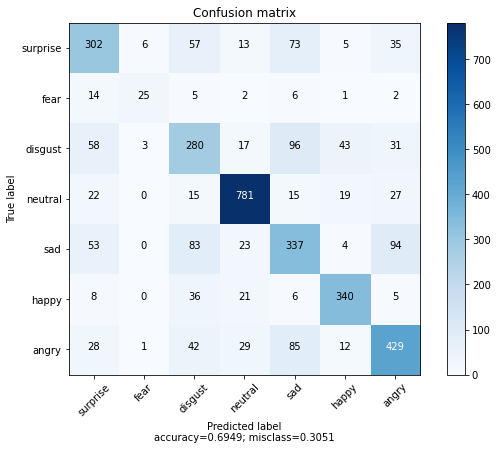

In [ ]:
target_name = ["surprise", "fear", "disgust" ,"neutral" ,"sad" ,"happy","angry"]
plot_confusion_matrix(a, target_name)

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/VIN/fer2013.csv')

In [ ]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [ ]:
df_test = df[df['Usage']=='PrivateTest']

In [ ]:
import numpy as np
y_label = []
X_test = np.zeros((len(df_test), 48, 48,3), dtype=np.uint8)
X_res = np.zeros((48, 48,3), dtype=np.uint8)
i = 0
for emotion, pixels in zip(df_test['emotion'], df_test['pixels']):
  y_label.append(emotion)

  list_of_pixels = pixels.split(' ')
  img_pixel = np.asarray(list_of_pixels, dtype=np.uint8).reshape(48,48,1)
  for k in range(48):
    for l in range(48):
      X_res[k,l,:] = img_pixel[k,l,0]
  X_test[i] = X_res
  i += 1

In [ ]:
X_test.shape

(3589, 48, 48, 3)

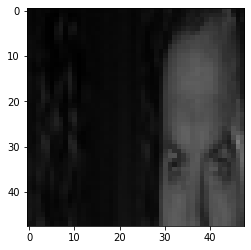

In [ ]:
plt.imshow(X_test[1])

In [ ]:
y_label = np.array(y_label)

In [ ]:
y_label

array([0, 5, 6, ..., 0, 3, 2])

In [ ]:
a = resize(X_test[1], (224,224,3))

In [ ]:
b =np.stack([resize(X_test[i], (224,224,3)) for i in range(y_label.shape[0])], axis = 0)

In [ ]:
b.shape

(3589, 224, 224, 3)

In [ ]:
c =model.predict(b)

In [ ]:
y_pred = [np.argmax(c[i]) for i in range(y_label.shape[0])]

In [ ]:
y_pred = np.array(y_pred)

In [ ]:
y_pred

array([0, 4, 2, ..., 0, 3, 2])

In [ ]:
y_label

array([0, 5, 6, ..., 0, 3, 2])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y_label, y_pred)

0.694901086653664